In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
    
# Các thư viện Scikit-learn (sklearn)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC  # Dùng SVM như trong bài giảng [cite: 1364]
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Tải dữ liệu
try:
    df = pd.read_csv('online_shoppers_intention.csv')
    print("Tải dữ liệu thành công!")
except FileNotFoundError:
    print("LỖI: Không tìm thấy tệp 'online_shoppers_intention.csv'.")


Tải dữ liệu thành công!


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [51]:
# Tiền xử lý nhanh: Chuyển đổi các cột chữ và logic thành số
print("Đang tiền xử lý...")
df_processed = pd.get_dummies(df, columns=['Month', 'VisitorType'], drop_first=True)
df_processed['Weekend'] = df_processed['Weekend'].astype(int)
df_processed['Revenue'] = df_processed['Revenue'].astype(int)

Đang tiền xử lý...


In [53]:
df_processed.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,VisitorType_Other,VisitorType_Returning_Visitor
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,True,False,False,False,False,False,False,False,False,True
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,...,True,False,False,False,False,False,False,False,False,True
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,...,True,False,False,False,False,False,False,False,False,True
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,...,True,False,False,False,False,False,False,False,False,True
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,...,True,False,False,False,False,False,False,False,False,True


In [55]:
# Giả sử bạn chạy head() TẠI ĐÂY
print(df_processed[['Weekend', 'Revenue']].head())

   Weekend  Revenue
0        0        0
1        0        0
2        0        0
3        0        0
4        1        0


In [59]:
# Tách X (đặc trưng) và y (mục tiêu)
X = df_processed.drop('Revenue', axis=1)
y = df_processed['Revenue']

In [61]:
# Chia dữ liệu NGAY TỪ ĐẦU
# Dùng stratify=y để giữ tỷ lệ mất cân bằng trong cả tập train và test [cite: 1436]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Tập huấn luyện có {len(X_train)} mẫu.")
print(f"Tập kiểm thử có {len(X_test)} mẫu.")

Tập huấn luyện có 9864 mẫu.
Tập kiểm thử có 2466 mẫu.


In [65]:
print("--- Yêu cầu 1: Biểu diễn dữ liệu ---")

# Đếm số lượng của lớp 'Revenue' (0 = Không mua, 1 = Mua hàng)
revenue_counts = y.value_counts()
print(revenue_counts)

--- Yêu cầu 1: Biểu diễn dữ liệu ---
Revenue
0    10422
1     1908
Name: count, dtype: int64


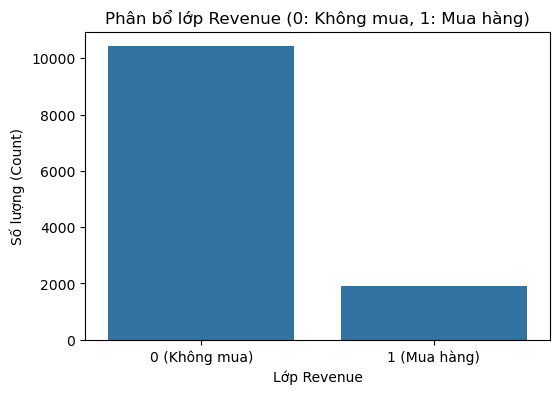

In [67]:
# Vẽ biểu đồ cột
plt.figure(figsize=(6, 4))
# Dùng sns.barplot để vẽ dễ hơn, nó vẫn dùng Matplotlib bên dưới
sns.barplot(x=revenue_counts.index, y=revenue_counts.values)

plt.title('Phân bổ lớp Revenue (0: Không mua, 1: Mua hàng)')
plt.xlabel('Lớp Revenue')
plt.ylabel('Số lượng (Count)')
plt.xticks([0, 1], ['0 (Không mua)', '1 (Mua hàng)'])
plt.show()

In [69]:
print("--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình Cơ sở) ---")

# --- Chuẩn hóa dữ liệu (Scaling) ---
# Bước bắt buộc cho SVM [cite: 3650, 2186]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Đã chuẩn hóa dữ liệu.")

--- Yêu cầu 2 & 3: Huấn luyện và Đánh giá (Mô hình Cơ sở) ---
Đã chuẩn hóa dữ liệu.


In [71]:
# --- Yêu cầu 2: Huấn luyện mô hình ---
# Dùng hàm .fit() [cite: 1238]
model_baseline = SVC(kernel='linear', random_state=42)
model_baseline.fit(X_train_scaled, y_train)
print("Đã huấn luyện xong mô hình SVM cơ sở.")

Đã huấn luyện xong mô hình SVM cơ sở.


In [73]:
# --- Yêu cầu 3: Đánh giá mô hình ---
# Dự đoán trên tập test
y_pred_baseline = model_baseline.predict(X_test_scaled)

In [75]:
# 3.1. Dùng Classification Report [cite: 1523]
print("\n--- Báo cáo Phân loại (Mô hình Cơ sở) ---")
report_baseline = classification_report(y_test, y_pred_baseline, 
                                        target_names=['0 (Không mua)', '1 (Mua hàng)'])
print(report_baseline)


--- Báo cáo Phân loại (Mô hình Cơ sở) ---
               precision    recall  f1-score   support

0 (Không mua)       0.89      0.98      0.93      2084
 1 (Mua hàng)       0.74      0.37      0.49       382

     accuracy                           0.88      2466
    macro avg       0.82      0.67      0.71      2466
 weighted avg       0.87      0.88      0.87      2466



--- Ma trận Nhầm lẫn (Mô hình Cơ sở) ---


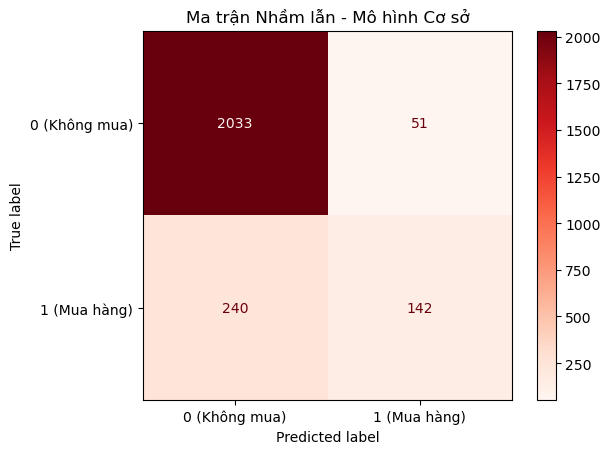

In [77]:
# 3.2. Dùng Confusion Matrix [cite: 1456]
print("--- Ma trận Nhầm lẫn (Mô hình Cơ sở) ---")
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_baseline, 
                            display_labels=['0 (Không mua)', '1 (Mua hàng)'])
disp.plot(cmap="Reds")
plt.title("Ma trận Nhầm lẫn - Mô hình Cơ sở")
plt.show()

In [79]:
print("--- Yêu cầu 4: Tinh chỉnh Mô hình (Cách 1: class_weight) ---")

# Huấn luyện mô hình mới, thêm class_weight='balanced'
model_tuned_1 = SVC(kernel='linear', 
                    class_weight='balanced', # <--- TINH CHỈNH Ở ĐÂY
                    random_state=42)
model_tuned_1.fit(X_train_scaled, y_train)
print("Đã huấn luyện xong mô hình SVM đã tinh chỉnh.")

--- Yêu cầu 4: Tinh chỉnh Mô hình (Cách 1: class_weight) ---
Đã huấn luyện xong mô hình SVM đã tinh chỉnh.


In [81]:
# Đánh giá mô hình đã tinh chỉnh
y_pred_tuned_1 = model_tuned_1.predict(X_test_scaled)

print("\n--- Báo cáo Phân loại (Mô hình Tinh chỉnh 1) ---")
report_tuned_1 = classification_report(y_test, y_pred_tuned_1, 
                                       target_names=['0 (Không mua)', '1 (Mua hàng)'])
print(report_tuned_1)


--- Báo cáo Phân loại (Mô hình Tinh chỉnh 1) ---
               precision    recall  f1-score   support

0 (Không mua)       0.94      0.90      0.92      2084
 1 (Mua hàng)       0.56      0.71      0.63       382

     accuracy                           0.87      2466
    macro avg       0.75      0.80      0.77      2466
 weighted avg       0.88      0.87      0.87      2466



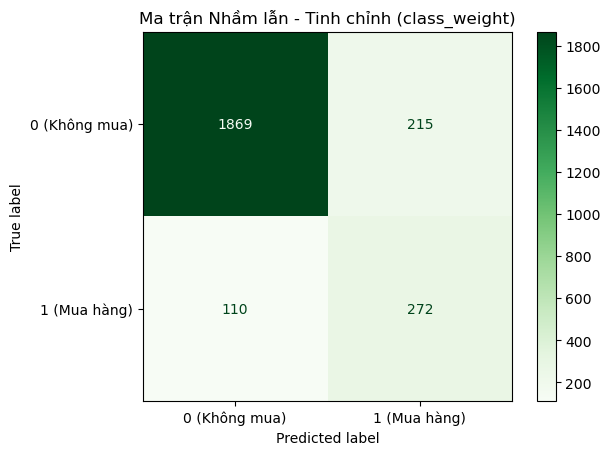

In [83]:
# Vẽ ma trận nhầm lẫn
cm_tuned_1 = confusion_matrix(y_test, y_pred_tuned_1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tuned_1, 
                            display_labels=['0 (Không mua)', '1 (Mua hàng)'])
disp.plot(cmap="Greens")
plt.title("Ma trận Nhầm lẫn - Tinh chỉnh (class_weight)")
plt.show()

In [86]:
print("--- Yêu cầu 4: Tinh chỉnh Mô hình (Cách 2: Grid Search) ---")

# Định nghĩa các tham số chúng ta muốn thử
# 'C' là tham số biên mềm (soft margin) [cite: 158]
param_grid = {
    'C': [0.1, 1, 10], # Thử 3 giá trị cho C
    'kernel': ['linear', 'rbf'] # Thử 2 loại kernel
}

# Khởi tạo GridSearch
# 'cv=3' là 3-fold cross-validation [cite: 1633]
# 'scoring='f1_weighted'' - chúng ta muốn tối ưu F1-score
grid_search = GridSearchCV(SVC(random_state=42, class_weight='balanced'), # Vẫn dùng class_weight
                           param_grid, 
                           cv=3, 
                           scoring='f1_weighted', 
                           verbose=2) # verbose=2 để in ra quá trình

print("Bắt đầu Grid Search...")
grid_search.fit(X_train_scaled, y_train)

# In ra kết quả tốt nhất
print("\nGrid Search hoàn tất!")
print(f"Các tham số tốt nhất tìm được: {grid_search.best_params_}")

# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

# --- Đánh giá mô hình tốt nhất (Best Model) ---
y_pred_best = best_model.predict(X_test_scaled)

print("\n--- Báo cáo Phân loại (Mô hình Tốt nhất từ GridSearch) ---")
report_best = classification_report(y_test, y_pred_best, 
                                    target_names=['0 (Không mua)', '1 (Mua hàng)'])
print(report_best)

--- Yêu cầu 4: Tinh chỉnh Mô hình (Cách 2: Grid Search) ---
Bắt đầu Grid Search...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ...............................C=0.1, kernel=linear; total time=   4.2s
[CV] END ...............................C=0.1, kernel=linear; total time=   2.9s
[CV] END ...............................C=0.1, kernel=linear; total time=   4.1s
[CV] END ..................................C=0.1, kernel=rbf; total time=   6.0s
[CV] END ..................................C=0.1, kernel=rbf; total time=   4.2s
[CV] END ..................................C=0.1, kernel=rbf; total time=   5.9s
[CV] END .................................C=1, kernel=linear; total time=   5.0s
[CV] END .................................C=1, kernel=linear; total time=   4.8s
[CV] END .................................C=1, kernel=linear; total time=   4.6s
[CV] END ....................................C=1, kernel=rbf; total time=   5.8s
[CV] END ....................................C=